In [1]:
# import things
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import patchify

2025-01-20 11:53:44.710991: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-20 11:53:44.722219: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737370424.736813   22794 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737370424.740987   22794 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-20 11:53:44.756148: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
patch_size = 960

In [3]:
def dice_loss(y_true, y_pred, smooth=1.0):
    # Ensure inputs are float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Flatten the inputs
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    
    # Calculate intersection and union
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    
    # Calculate Dice coefficient
    dice = (2. * intersection + smooth) / (union + smooth)
    
    return 1 - dice

def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    # Ensure inputs are float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    gamma = tf.cast(gamma, tf.float32)
    alpha = tf.cast(alpha, tf.float32)
    
    # Clip prediction values to avoid log(0)
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
    
    # Calculate focal loss
    pt = tf.where(y_true == 1, y_pred, 1 - y_pred)
    alpha_factor = tf.ones_like(y_true, dtype=tf.float32) * alpha
    alpha_factor = tf.where(y_true == 1, alpha_factor, 1 - alpha_factor)
    
    focal_weight = alpha_factor * tf.pow(1 - pt, gamma)
    
    bce = -tf.math.log(pt)
    loss = focal_weight * bce
    
    return tf.reduce_mean(loss)
    
def weighted_bce(y_true, y_pred, pos_weight=10.0):
    """Weighted binary cross-entropy to handle class imbalance"""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
    
    # Calculate weighted BCE
    pos_weight = tf.constant(pos_weight, dtype=tf.float32)
    bce = -(pos_weight * y_true * tf.math.log(y_pred) + 
            (1 - y_true) * tf.math.log(1 - y_pred))
    return tf.reduce_mean(bce)

def precision_focused_loss(y_true, y_pred, beta=2.0):
    # Ensure inputs are float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    beta = tf.cast(beta, tf.float32)
    
    # Calculate true positives, false positives, and false negatives
    TP = tf.reduce_sum(y_true * y_pred)
    FP = tf.reduce_sum((1 - y_true) * y_pred)
    FN = tf.reduce_sum(y_true * (1 - y_pred))
    
    # Calculate precision and recall
    precision = TP / (TP + FP + K.epsilon())
    recall = TP / (TP + FN + K.epsilon())
    
    # Calculate F-beta score
    beta_squared = beta * beta
    f_beta = (1 + beta_squared) * precision * recall / (beta_squared * precision + recall + K.epsilon())
    
    return 1 - f_beta

def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3, smooth=1e-5):
    """Tversky loss with asymmetric weighting for better handling of FP and FN"""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Calculate True Positives, False Positives, and False Negatives
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    
    # Calculate Tversky index
    tversky = (tp + smooth) / (tp + alpha * fp + beta * fn + smooth)
    return 1 - tversky

def boundary_loss(y_true, y_pred, theta=1.5):
    """Boundary-aware loss to focus on root edges"""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Calculate gradients using Sobel filters
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    
    # Calculate boundary magnitude
    boundary_true = tf.sqrt(tf.square(dx_true) + tf.square(dy_true))
    boundary_pred = tf.sqrt(tf.square(dx_pred) + tf.square(dy_pred))
    
    # Calculate boundary loss
    boundary_diff = tf.abs(boundary_true - boundary_pred)
    weighted_diff = boundary_diff * tf.pow(boundary_true, theta)
    
    return tf.reduce_mean(weighted_diff)

def combined_loss(y_true, y_pred):
    """Comprehensive loss function for plant root segmentation"""
    # Cast inputs to float32 and clip predictions
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1.0 - K.epsilon())
    
    # Weight factors for each loss component
    dice_weight = tf.constant(1.0, dtype=tf.float32)
    focal_weight = tf.constant(2.5, dtype=tf.float32)
    precision_weight = tf.constant(1.5, dtype=tf.float32)
    tversky_weight = tf.constant(1.5, dtype=tf.float32)
    boundary_weight = tf.constant(0.5, dtype=tf.float32)
    
    try:
        # Calculate individual losses with error handling
        d_loss = dice_loss(y_true, y_pred, smooth=1e-5)
        f_loss = focal_loss(y_true, y_pred, gamma=3.0, alpha=0.75)
        p_loss = precision_focused_loss(y_true, y_pred, beta=0.75)
        t_loss = tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3)
        bound_loss = boundary_loss(y_true, y_pred, theta=1.5)
        
        # Check for NaN values
        losses = [d_loss, f_loss, p_loss, t_loss, bound_loss]
        for loss in losses:
            if tf.reduce_any(tf.math.is_nan(loss)):
                # If NaN detected, return a safe fallback loss
                return dice_loss(y_true, y_pred, smooth=1e-5)
        
        # Combine losses with fixed weights
        total_loss = (
            dice_weight * d_loss +
            focal_weight * f_loss +
            precision_weight * p_loss +
            tversky_weight * t_loss +
            boundary_weight * bound_loss
        )
        
        # Final NaN check
        if tf.reduce_any(tf.math.is_nan(total_loss)):
            return dice_loss(y_true, y_pred, smooth=1e-5)
            
        return total_loss
        
    except Exception as e:
        # If any error occurs, fallback to dice loss
        print(f"Error in combined loss: {e}")
        return dice_loss(y_true, y_pred, smooth=1e-5)

# Test the loss function
def test_loss_function():
    # Create test data
    y_true = tf.random.uniform((4, 64, 64, 1), 0, 2, dtype=tf.int32)
    y_pred = tf.random.uniform((4, 64, 64, 1), 0, 1, dtype=tf.float32)
    
    # Calculate loss
    loss = combined_loss(y_true, y_pred)
    print(f"Test loss value: {loss.numpy()}")
    return loss

test_loss_function()

I0000 00:00:1735814087.397564    2288 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Test loss value: 2.928488254547119


<tf.Tensor: shape=(), dtype=float32, numpy=2.928488254547119>

In [4]:
def f1(y_true, y_pred):

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Test the f1 score
y_true = np.array([[1, 0, 1], [0, 1, 0], [1, 0, 1]])
y_pred = np.array([[1, 0, 1], [0, 1, 0], [1, 0, 1]])
f1(y_true, y_pred)


<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [5]:
def unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    # Input layer 
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    # Convert grayscale to RGB and resize
    if IMG_CHANNELS == 1:
        x = tf.keras.layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x))(inputs)
    else:
        x = inputs
    x = tf.keras.layers.Resizing(224, 224)(x)
    
    # Load MobileNet with the correct input shape
    base_model = tf.keras.applications.MobileNet(
        input_tensor=x,
        include_top=False,
        weights='imagenet'
    )
    
    # Get skip connections
    s1 = base_model.get_layer('conv_pw_1_relu').output  # 112x112
    s2 = base_model.get_layer('conv_pw_3_relu').output  # 56x56
    s3 = base_model.get_layer('conv_pw_5_relu').output  # 28x28
    s4 = base_model.get_layer('conv_pw_11_relu').output # 14x14
    
    # Bridge
    bridge = base_model.get_layer('conv_pw_13_relu').output  # 7x7
    
    # Decoder path with batch normalization and dropout
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    u6 = concatenate([u6, s4])
    u6 = tf.keras.layers.BatchNormalization()(u6)
    u6 = tf.keras.layers.Dropout(0.3)(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = tf.keras.layers.BatchNormalization()(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, s3])
    u7 = tf.keras.layers.BatchNormalization()(u7)
    u7 = tf.keras.layers.Dropout(0.3)(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = tf.keras.layers.BatchNormalization()(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, s2])
    u8 = tf.keras.layers.BatchNormalization()(u8)
    u8 = tf.keras.layers.Dropout(0.2)(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = tf.keras.layers.BatchNormalization()(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, s1])
    u9 = tf.keras.layers.BatchNormalization()(u9)
    u9 = tf.keras.layers.Dropout(0.1)(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = tf.keras.layers.BatchNormalization()(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    # Final layers with stronger activation
    outputs = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
    outputs = Conv2D(32, (3, 3), activation='relu', padding='same')(outputs)
    outputs = tf.keras.layers.BatchNormalization()(outputs)
    outputs = Conv2D(16, (3, 3), activation='relu', padding='same')(outputs)
    outputs = tf.keras.layers.BatchNormalization()(outputs)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(outputs)

    # Add batch normalization and dropout for better training
    outputs = tf.keras.layers.BatchNormalization()(outputs)
    outputs = tf.keras.layers.Dropout(0.3)(outputs)
    
    # Resize back to original dimensions
    final_outputs = tf.keras.layers.Resizing(IMG_HEIGHT, IMG_WIDTH)(outputs)
    
    model = Model(inputs=inputs, outputs=final_outputs)
    model.compile(
        optimizer='adam', 
        loss=combined_loss, 
        metrics=[
            f1,
            'accuracy',
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall()
        ]
    )
    
    return model

In [6]:
# Build U-Net
# REQUIREMENT: Model summary must be visible
model = unet_model(
    IMG_HEIGHT=patch_size,
    IMG_WIDTH=patch_size,
    IMG_CHANNELS=1
)

# Load the weight if it exists
# model.load_weights(f'soheil_6989490_unet_model_{patch_size}px.h5')
model.load_weights('best_model.weights.h5')

# model.summary()

/tmp/ipykernel_429968/4055785752.py:13: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNet(
/home/FireFury/miniconda3/envs/plant2/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 272 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [7]:
# Load the test image
task5_test_image_path = 'task5_test_image.png'
image = cv2.imread(task5_test_image_path, 0)
h, w = image.shape
print(h, w)

3006 4112


In [8]:
def extract_petri_dish(image):
    """
    Extracts a square region containing the Petri dish from the input image.
    
    Args:
        image: Input grayscale image
        
    Returns:
        Cropped square image containing the Petri dish
    """
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Use Otsu's thresholding to separate dish from background
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the largest contour (should be the Petri dish)
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Get bounding rectangle
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Calculate the size of the square crop (use larger dimension)
    size = max(w, h)
    
    # Calculate new coordinates to center the dish
    center_x = x + w//2
    center_y = y + h//2
    
    # Calculate crop coordinates
    x1 = max(0, center_x - size//2)
    y1 = max(0, center_y - size//2)
    x2 = min(image.shape[1], x1 + size)
    y2 = min(image.shape[0], y1 + size)
    
    # Crop the image
    cropped = image[y1:y2, x1:x2]
    
    return cropped, (x1, y1, x2, y2)

(2742, 2742)


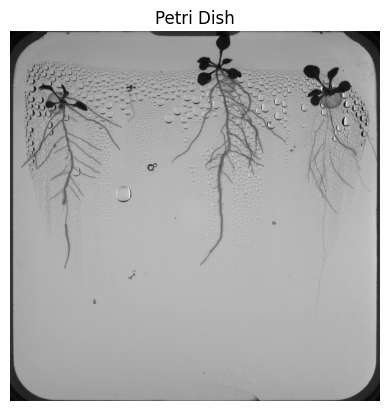

In [9]:
# Extract the petri dish
petri_dish, petri_dish_coords = extract_petri_dish(image)

# Shape
print(petri_dish.shape)

# Plot the petri dish
plt.imshow(petri_dish, cmap='gray')
plt.title('Petri Dish')
plt.axis('off')
plt.show()

In [10]:
def padder(image, patch_size):
    """
    Adds padding to an image to make its dimensions divisible by a specified patch size.

    This function calculates the amount of padding needed for both the height and width of an image so that its dimensions become divisible by the given patch size. The padding is applied evenly to both sides of each dimension (top and bottom for height, left and right for width). If the padding amount is odd, one extra pixel is added to the bottom or right side. The padding color is set to black (0, 0, 0).

    Parameters:
    - image (numpy.ndarray): The input image as a NumPy array. Expected shape is (height, width, channels).
    - patch_size (int): The patch size to which the image dimensions should be divisible. It's applied to both height and width.

    Returns:
    - numpy.ndarray: The padded image as a NumPy array with the same number of channels as the input. Its dimensions are adjusted to be divisible by the specified patch size.

    Example:
    - padded_image = padder(cv2.imread('example.jpg'), 128)

    """
    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding/2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding/2)
    right_padding = width_padding - left_padding

    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_image

(2880, 2880)


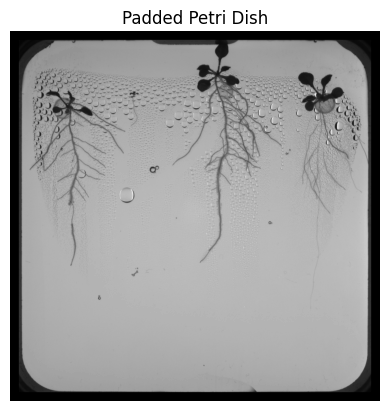

In [11]:
padded_petri_dish = padder(petri_dish, patch_size)

print(padded_petri_dish.shape)

plt.imshow(padded_petri_dish, cmap='gray')
plt.title('Padded Petri Dish')
plt.axis('off')
plt.show()

Original shape: (2880, 2880, 1)
Patches shape: (3, 3, 960, 960)


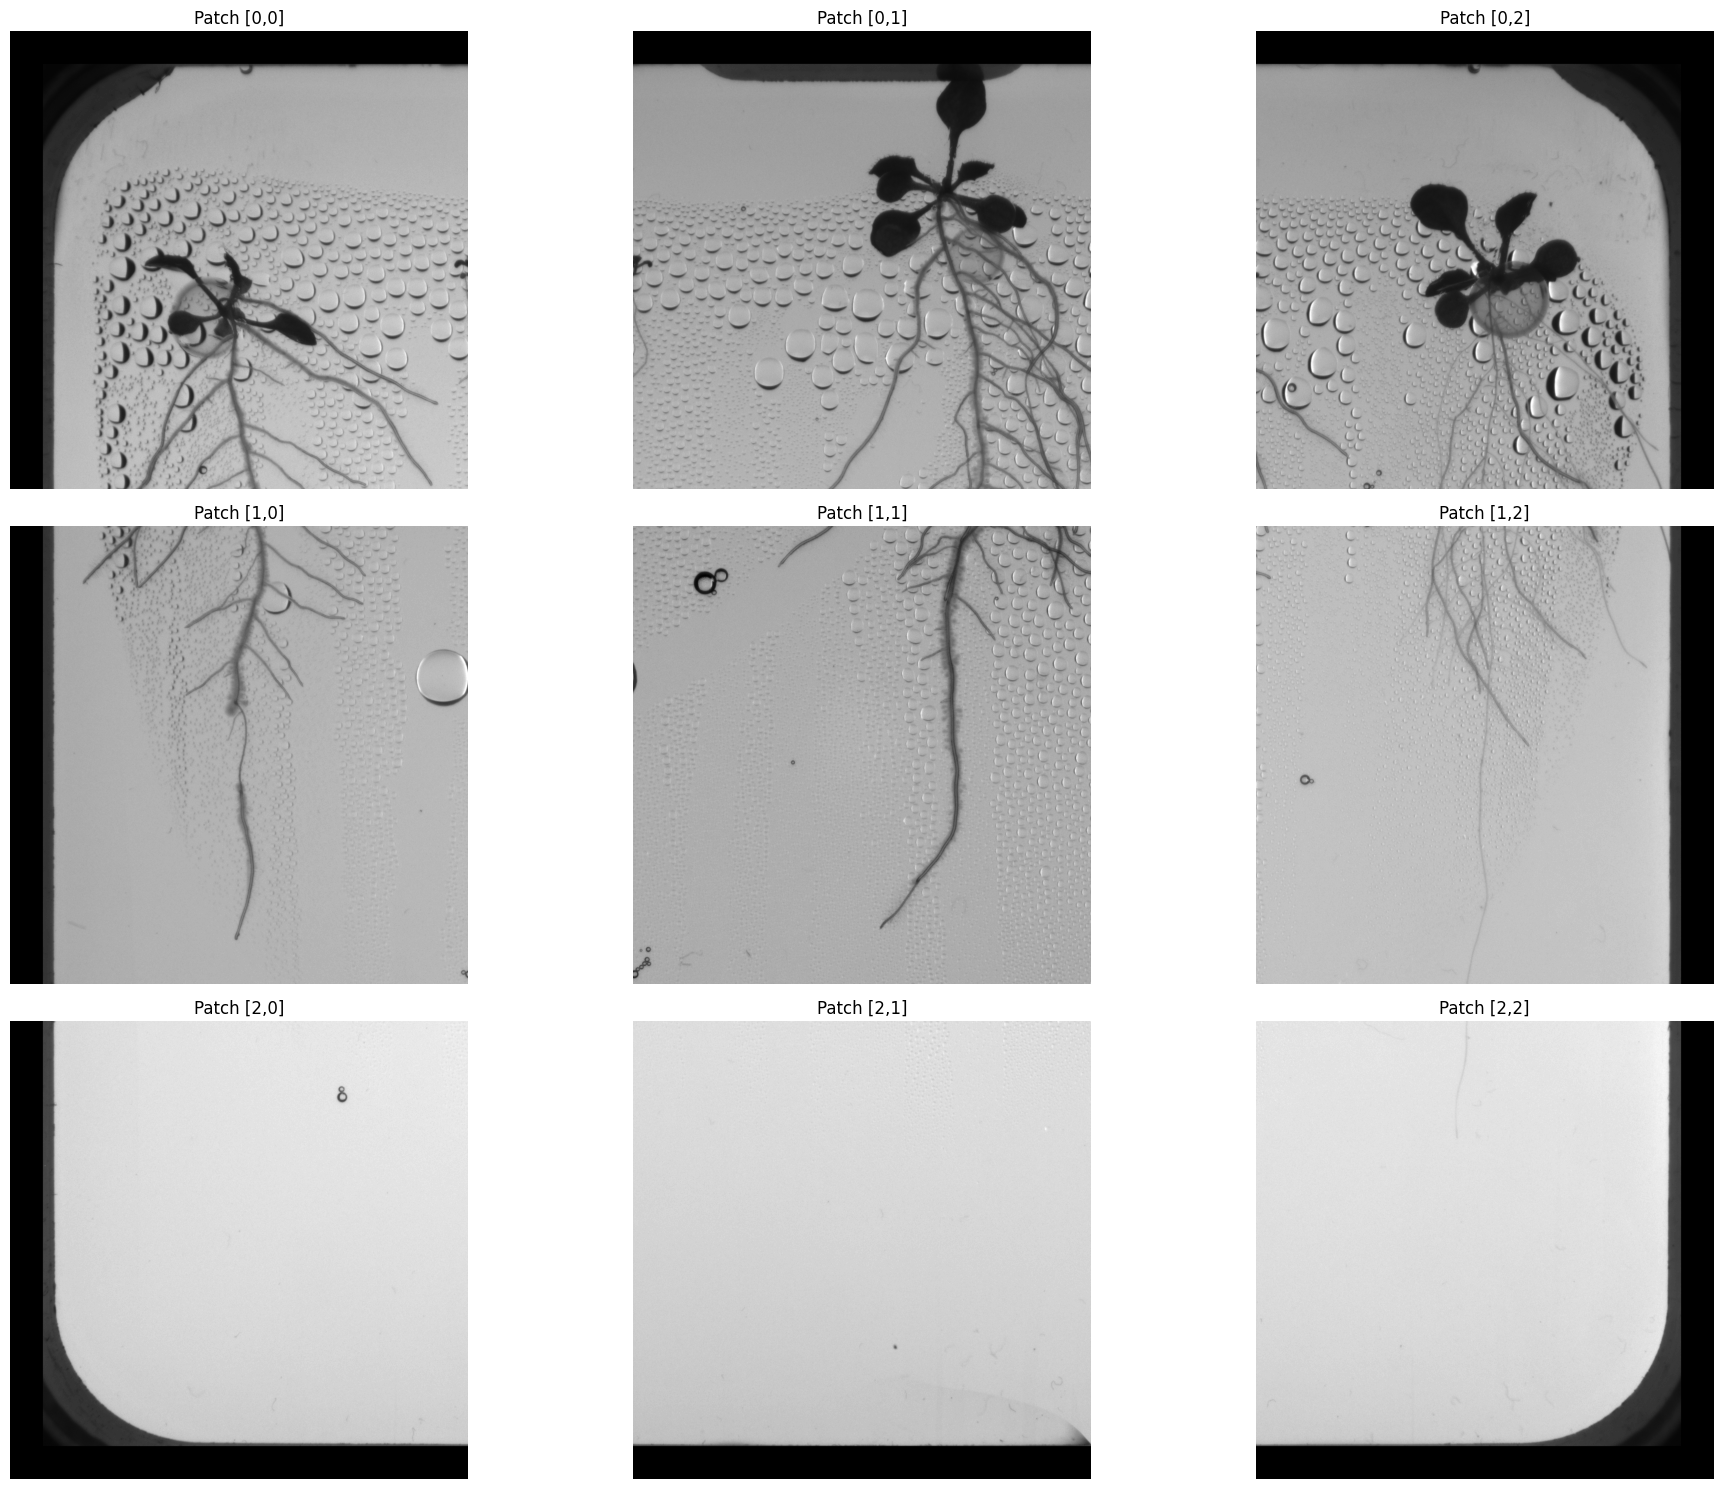

In [12]:
def create_patches(image, patch_size):
    # Add channel dimension if needed
    if len(image.shape) == 2:
        image = image[..., np.newaxis]  # Add channel dimension
    
    # Create patches
    patches = patchify.patchify(image, (patch_size, patch_size, 1), step=patch_size)
    
    # Remove the extra dimensions when returning
    patches = patches[:, :, 0, :, :, 0]
    
    print(f"Original shape: {image.shape}")
    print(f"Patches shape: {patches.shape}")
    return patches, image[:, :, 0]  # Return 2D image

# Create patches with the fixed function
patches, petri_dish = create_patches(padded_petri_dish, patch_size)

# Visualize patches to verify
plt.figure(figsize=(20, 15))
n_rows, n_cols = patches.shape[0], patches.shape[1]

for i in range(n_rows):
    for j in range(n_cols):
        plt.subplot(n_rows, n_cols, i*n_cols + j + 1)
        plt.imshow(patches[i, j], cmap='gray')
        plt.title(f'Patch [{i},{j}]')
        plt.axis('off')

plt.tight_layout()
plt.show()

In [24]:
# Z score normalization for image
def z_score_normalization(image):
    mean = np.mean(image)
    std = np.std(image)
    normalized_image = (image - mean) / std
    return normalized_image


In [36]:
# Predict each patches and visualize them

# Prepare patches for prediction
n_patches_h, n_patches_w = patches.shape[0], patches.shape[1]
patches_reshaped = patches.reshape(-1, patch_size, patch_size)

# Create array to store predictions
predictions = []

# Predict each patch
for patch in patches_reshaped:

    # Add batch and channel dimensions
    patch_input = patch[np.newaxis, ..., np.newaxis]
    
    # Z-score normalization
    patch_input = z_score_normalization(patch_input)
    
    # Predict
    pred = model.predict(patch_input, verbose=0)
    predictions.append(pred[0, ..., 0])  # Remove batch and channel dimensions

# Reshape predictions back to match original patch layout
predictions = np.array(predictions)
predictions = predictions.reshape(n_patches_h, n_patches_w, patch_size, patch_size)

# Store the predictions for later use
predicted_patches = predictions

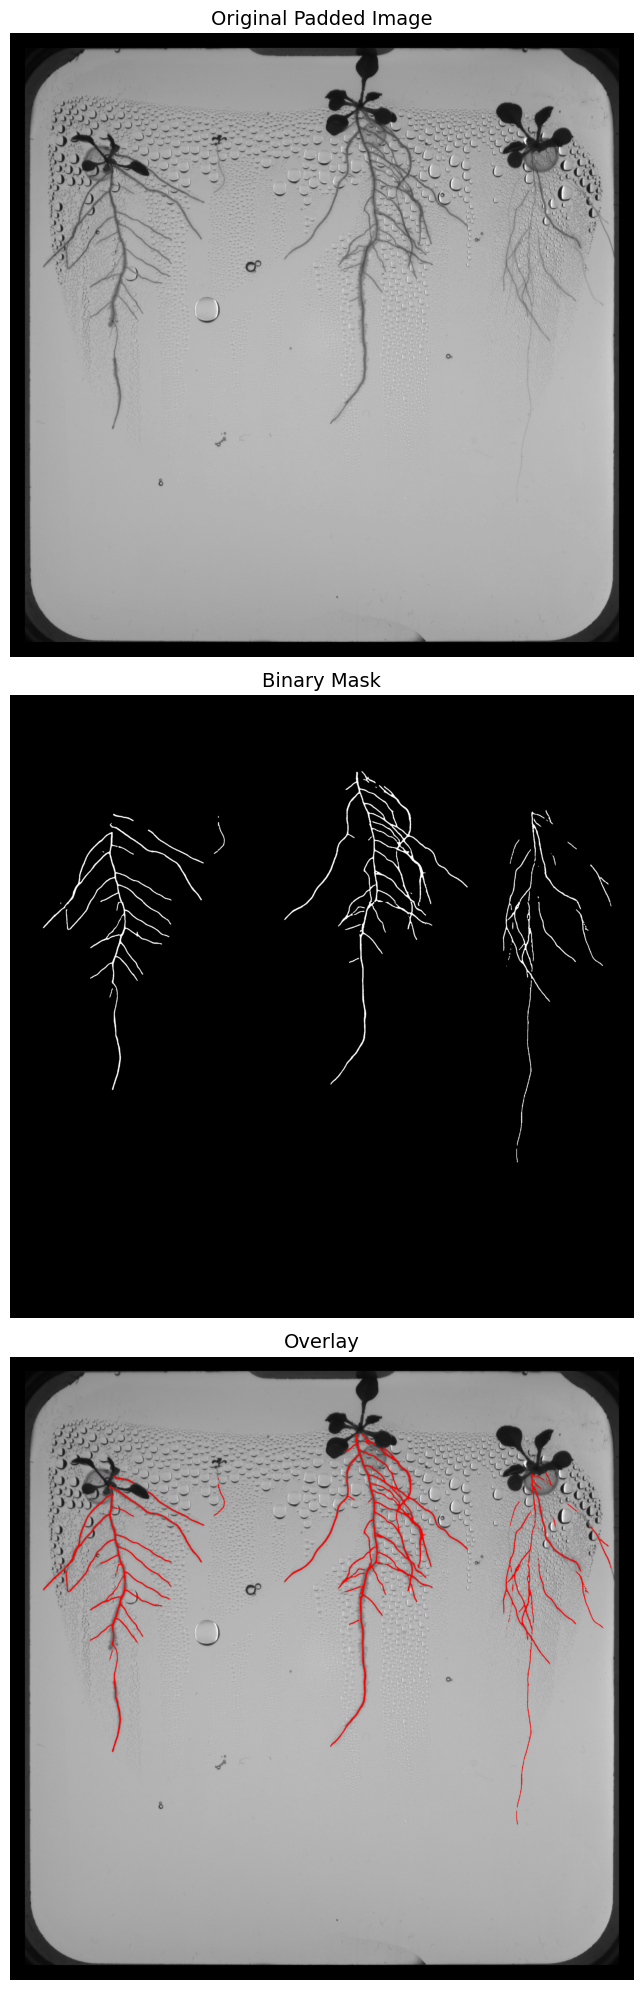

In [37]:
# Put all the predicted mask together
reconstructed = patchify.unpatchify(predicted_patches, 
                                  (n_patches_h * patch_size, 
                                   n_patches_w * patch_size))
                                   
# Threshold with a slightly higher value to remove noise
binary_mask = (reconstructed > 0.6).astype(np.uint8) * 255

# Remove small artifacts (adjust kernel size if needed)
kernel = np.ones((3,3), np.uint8)
binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)

# Visualize the binary mask
plt.figure(figsize=(20, 20))  

# Original padded image
plt.subplot(311)
plt.imshow(padded_petri_dish, cmap='gray')
plt.title('Original Padded Image', fontsize=14)  
plt.axis('off')

# Binary mask
plt.subplot(312)
plt.imshow(binary_mask, cmap='gray')
plt.title('Binary Mask', fontsize=14)
plt.axis('off')

# Overlay
plt.subplot(313)
overlay = cv2.cvtColor(padded_petri_dish.astype(np.uint8), cv2.COLOR_GRAY2BGR)
overlay[binary_mask > 0] = [0, 0, 255]  # Red color for predictions
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title('Overlay', fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()

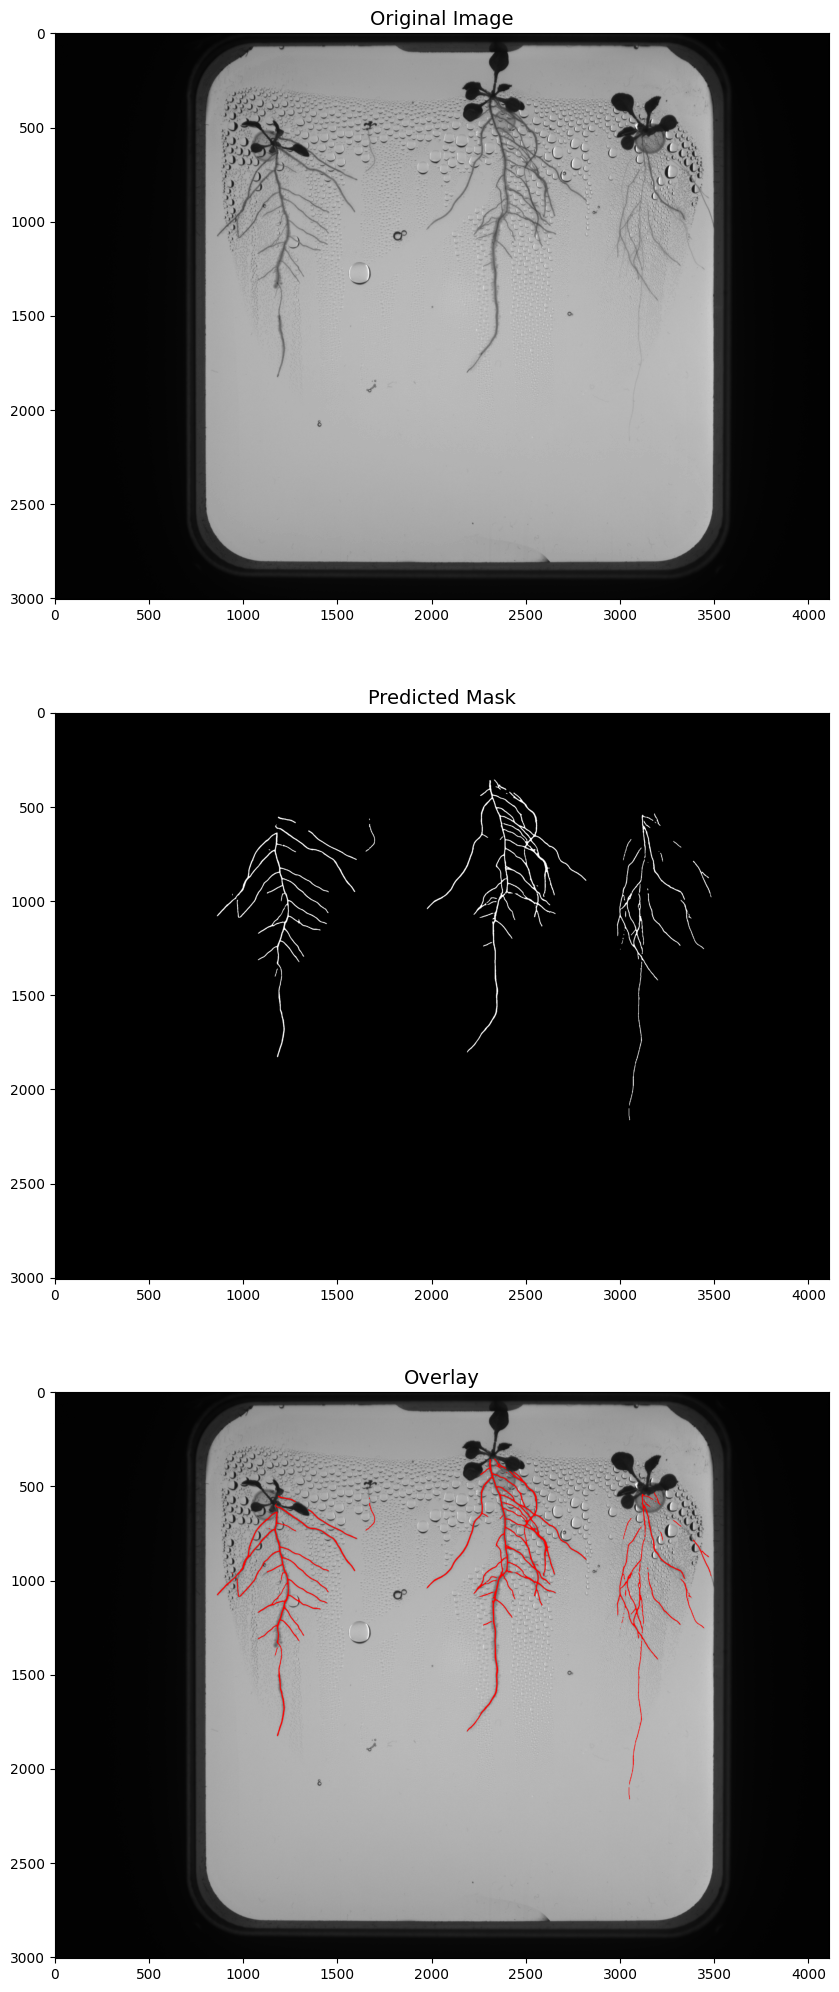

In [39]:
# Reverse the cropping and padding on all of the images
def reverse_padding_and_cropping(predicted_mask, original_shape, petri_coords):
    """
    Reverses the padding and cropping operations to align the predicted mask with the original image.
    
    Args:
        predicted_mask: The mask after prediction (padded)
        original_shape: Shape of the original image (h, w)
        petri_coords: Coordinates of petri dish crop (x1, y1, x2, y2)
    
    Returns:
        Final mask aligned with the original image
    """
    # 1. Remove padding from the predicted mask
    x1, y1, x2, y2 = petri_coords
    crop_height = y2 - y1
    crop_width = x2 - x1
    
    # Calculate padding amounts that were added
    h_pad = predicted_mask.shape[0] - crop_height
    w_pad = predicted_mask.shape[1] - crop_width
    
    # Remove padding
    top_pad = h_pad // 2
    left_pad = w_pad // 2
    unpadded_mask = predicted_mask[top_pad:top_pad+crop_height, 
                                 left_pad:left_pad+crop_width]
    
    # 2. Place the unpadded mask back in the original image size
    final_mask = np.zeros(original_shape, dtype=np.float32)
    final_mask[y1:y2, x1:x2] = unpadded_mask
    
    return final_mask

# Apply the corrections
predicted_mask_corrected = reverse_padding_and_cropping(
    binary_mask,          # Our predicted mask (padded)
    image.shape,          # Original image shape
    petri_dish_coords     # Coordinates from extract_petri_dish
)

# Create an overlay to verify alignment
overlay_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
overlay_image[predicted_mask_corrected > 0] = [255, 0, 0]  # Red color for predictions

# Visualize the overlay
plt.figure(figsize=(25, 25))
plt.subplot(311)
plt.imshow(image, cmap='gray')
plt.title('Original Image', fontsize=14)
plt.subplot(312)
plt.imshow(predicted_mask_corrected, cmap='gray')
plt.title('Predicted Mask', fontsize=14)
plt.subplot(313)
plt.imshow(overlay_image)
plt.title('Overlay', fontsize=14)
plt.show()

Original shape: (2880, 2880, 1)
Patches shape: (3, 3, 960, 960)


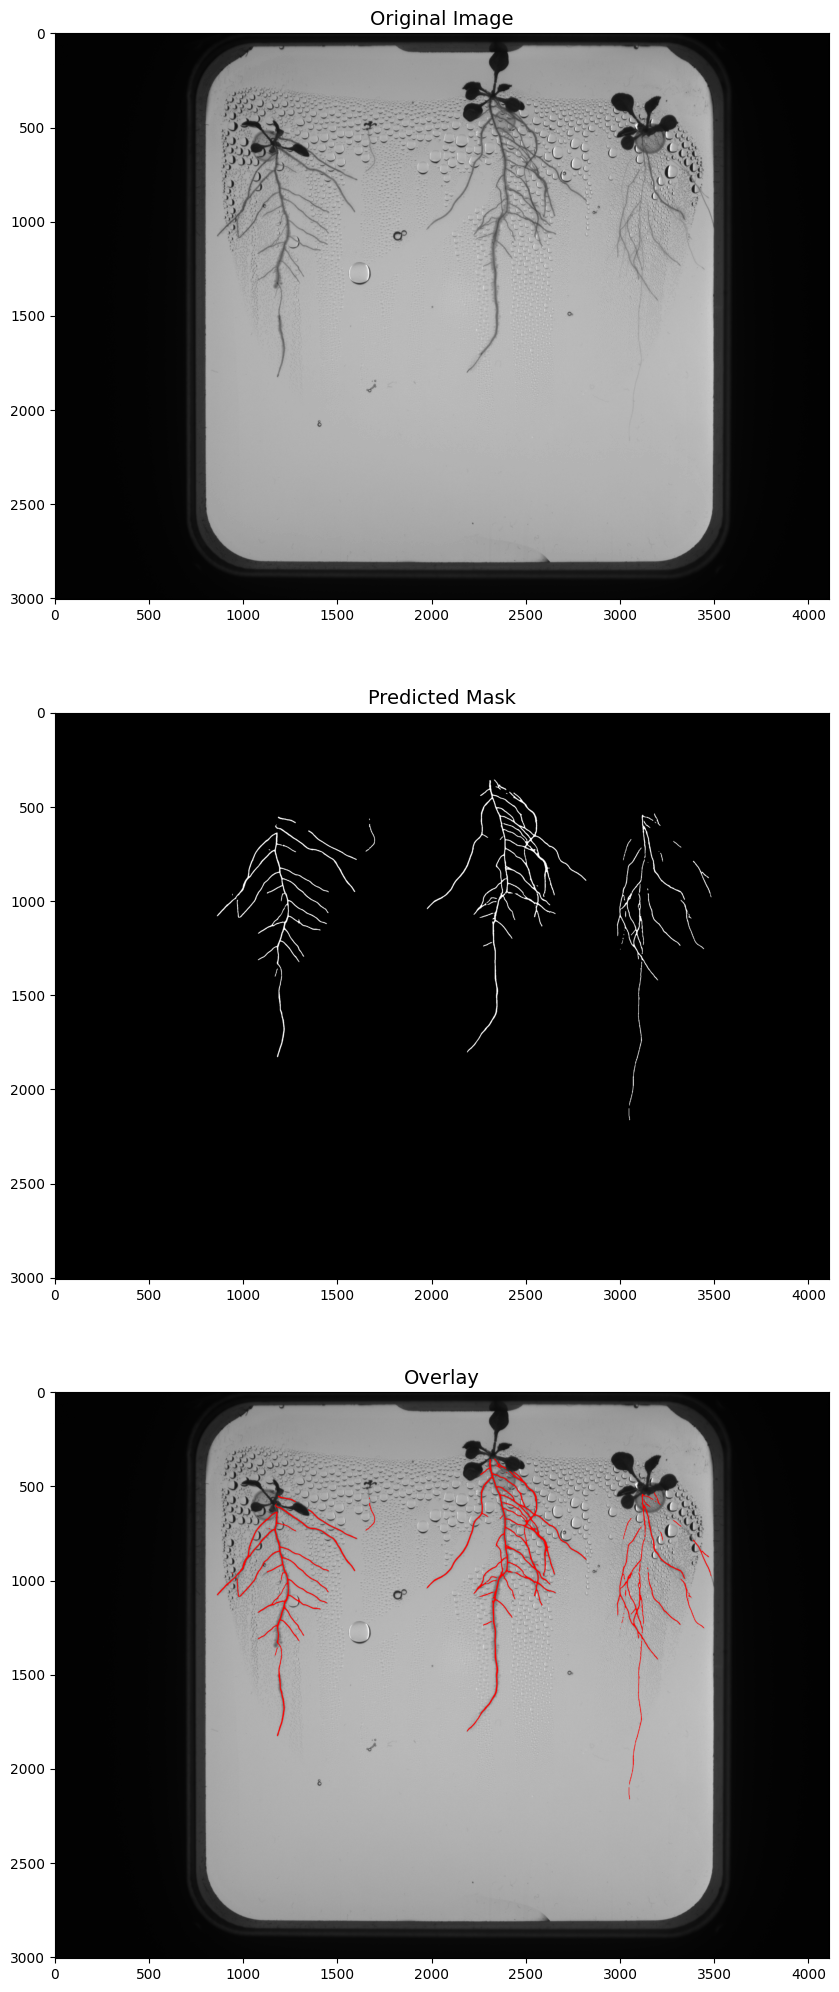

True

In [43]:
def predict_roots(image_path, model_path, patch_size=960, threshold=0.6):
    """
    Predicts root segments in a plant image using a trained U-Net model.
    
    Args:
        image_path (str): Path to the input image
        model_path (str): Path to the trained model weights
        patch_size (int): Size of patches for processing (default: 960)
        threshold (float): Threshold for binary mask creation (default: 0.6)
    
    Returns:
        tuple: (predicted_mask, overlay_image) where:
            - predicted_mask: Binary mask of predicted roots (same size as input)
            - overlay_image: Original image with predicted roots highlighted
    """
    # Load the image
    image = cv2.imread(image_path, 0)

    # Increase the contrast of the image
    # clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    # image = clahe.apply(image)
    
    # Extract petri dish
    petri_dish, petri_coords = extract_petri_dish(image)
    
    # Add padding
    padded_petri = padder(petri_dish, patch_size)
    
    # Create patches
    patches, _ = create_patches(padded_petri, patch_size)
    
    # Prepare patches for prediction
    n_patches_h, n_patches_w = patches.shape[0], patches.shape[1]
    patches_reshaped = patches.reshape(-1, patch_size, patch_size)
    
    # Load model if path is provided
    # if isinstance(model_path, str):
    #     model = load_model(model_path, custom_objects={"f1": f1})
    # else:
    #     model = model_path  # Assume model object was passed directly
    
    # Predict patches
    predictions = []
    for patch in patches_reshaped:
        patch_input = patch[np.newaxis, ..., np.newaxis] #/ 255.0
        patch_input = z_score_normalization(patch_input)
        pred = model.predict(patch_input, verbose=0)
        predictions.append(pred[0, ..., 0])
    
    # Reshape predictions
    predictions = np.array(predictions)
    predictions = predictions.reshape(n_patches_h, n_patches_w, patch_size, patch_size)
    
    # Reconstruct full image
    reconstructed = patchify.unpatchify(predictions, 
                                      (n_patches_h * patch_size, 
                                       n_patches_w * patch_size))
    
    # Create binary mask
    binary_mask = (reconstructed > threshold).astype(np.uint8) * 255
    
    # Clean up mask
    kernel = np.ones((3,3), np.uint8)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
    
    # Reverse padding and cropping
    predicted_mask = reverse_padding_and_cropping(
        binary_mask,
        image.shape,
        petri_coords
    )
    
    # Create overlay
    overlay_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    overlay_image[predicted_mask > 0] = [255, 0, 0] 
    
    return predicted_mask, overlay_image

# Example usage:
image_path = 'task5_test_image.png'
model_path = f'soheil_6989490_unet_model_{patch_size}px.h5'

# Get predictions
mask, overlay = predict_roots(image_path, model_path)

# Visualize results
plt.figure(figsize=(25, 25))
plt.subplot(311)
plt.imshow(cv2.imread(image_path, 0), cmap='gray')
plt.title('Original Image', fontsize=14)
plt.subplot(312)    
plt.imshow(mask, cmap='gray')
plt.title('Predicted Mask', fontsize=14)
plt.subplot(313)
plt.imshow(overlay)
plt.title('Overlay', fontsize=14)
plt.show()

# Save the prediction
cv2.imwrite('task5_test_image_prediction_soheil_6989490.png', mask)

In [44]:
# REQUIREMENT: Save the predicted mask, it is a deliverable.
# REQUIREMENT: Input/Output size must be the same.
# REQUIREMENT: Predicted roots must align with the original image.
# REQUIREMENT: The predicted mask must be binary.
# REQUIREMENT: Non-root pixels must be 0, root pixels must be 255 (unlike Task 1)
# REQUIREMENT: naming convention task5_test_image_prediction_studentname_studentnumber.png
mask_image = (predicted_mask_corrected * 255).astype(np.uint8)
assert(predicted_mask_corrected.shape == image.shape)
cv2.imwrite('task5_test_image_prediction_soheil_6989490.png', mask_image)

True